# Condensation Tutorial: Mass Binned

**NEEDS REVISION: integration unstable**

A mass binned model is relaxes the assumption of a single composition for all particles in a given bin. Instead, it allows for a distribution of compositions within each bin. This is useful when the composition of particles is separated by masses. This does not account for the same sized particles having different compositions, but rather different sized particles having different compositions.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.gas.atmosphere_builders import AtmosphereBuilder
from particula.next.gas.vapor_pressure_factories import VaporPressureFactory
from particula.next.gas.species_builders import GasSpeciesBuilder
from particula.next.aerosol import Aerosol
from particula.next.dynamics.particle_process import MassCondensation
from particula.next.dynamics.condensation.condensation_strategies import CondensationIsothermal

## Aerosol Setup

First we'll draw from a lognormal distribution to create a set of particles. We'll will then build an aerosol object to represent the aerosol population.


In [12]:
# Ammonium sulfate and water vapor pressure
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
molar_mass_water = 18.015e-3  # kg/mol
parameters_vapor = {
    "vapor_pressure": 1e-20,
}
vapor_pressure_ammonium = VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)
vapor_pressure_water = VaporPressureFactory().get_strategy(
    "water_buck"
)

water_sat = vapor_pressure_water.saturation_concentration(molar_mass=molar_mass_water, temperature=298.15)
water_concentration = 0.8 * water_sat

glycerol_gas = (
    GasSpeciesBuilder()
    .set_molar_mass(np.array([molar_mass_water, molar_mass_ammonium_sulfate]), "kg/mol")
    .set_vapor_pressure_strategy([vapor_pressure_water, vapor_pressure_ammonium])
    .set_concentration(np.array([water_concentration, 0.0]), "kg/m^3")
    .set_name(["H2O", "NH4HSO4"])
    .set_condensable([True, True])
    .build()
)

atmosphere = (
    AtmosphereBuilder()
    .add_species(glycerol_gas)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)




**Sample Distribution**

Next we'll sample the distribution to get a set of particles. We'll then build an aerosol object to represent the aerosol population.

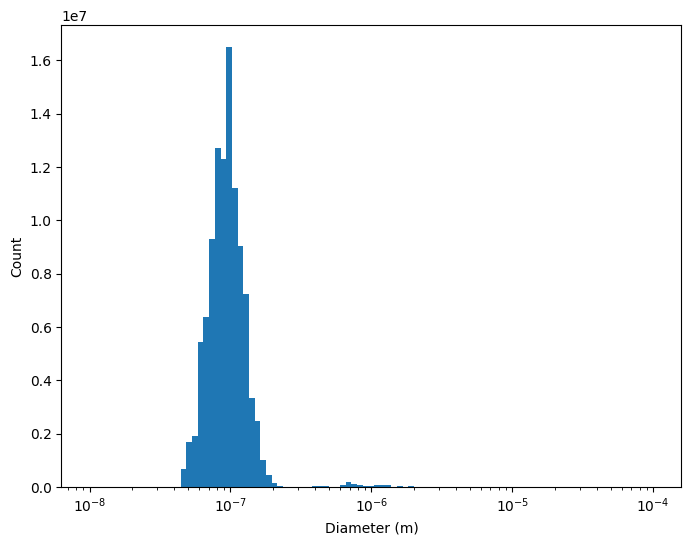

In [13]:
# sample
particles_sample = particles.properties.lognormal_sample_distribution(
    mode=np.array([100, 1000])*1e-9,
    geometric_standard_deviation=np.array([1.3, 1.5]),
    number_of_particles=np.array([1e3, 1e2]),
    number_of_samples=1000,
)

# histogram lognormal
bins_lognormal = np.logspace(-8, -4, 100)
bins, edges = np.histogram(particles_sample, bins=bins_lognormal, density=True)
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge")
ax.set_xscale("log")
ax.set_xlabel("Diameter (m)")
ax.set_ylabel("Count")
plt.show()

In [14]:
# particle radis to mass
density = 1.26e3  # kg/m^3
particle_mass = density * 4 / 3 * np.pi * particles_sample ** 3
mass_speciation = np.array([particle_mass*0, particle_mass]).T  # water, ammonium sulfate
concentration = np.ones_like(particles_sample) * 1e1
densities = np.array([1000, 1.26e3])  # kg/m^3

print(mass_speciation.shape)

activity_strat = (
    particles.ActivityKappaParameterBuilder()
    .set_density(densities)
    .set_kappa(np.array([0.0, 0.61]))
    .set_molar_mass(np.array([molar_mass_water, molar_mass_ammonium_sulfate]))
    .set_water_index(0)
    .build()
)

surface_strat = (
    particles.SurfaceStrategyVolumeBuilder()
    .set_density(densities)
    .set_surface_tension(np.array([0.072, 0.092]))
    .build()
)

paritcle_rep = (
    particles.ParticleMassRepresentationBuilder()
    .set_distribution_strategy(particles.SpeciatedMassMovingBinBuilder().build())
    .set_surface_strategy(surface_strat)
    .set_activity_strategy(activity_strat)
    .set_density(densities)
    .set_charge(0.0)
    .set_mass(mass_speciation)
    .set_concentration(concentration, "1/cm^3")
    .build()
)

aerosol = Aerosol(atmosphere=atmosphere, particles=paritcle_rep)

print(aerosol)

(1000, 2)
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['H2O', 'NH4HSO4']"]
[0]: Particle Representation:
	Strategy: SpeciatedMassMovingBin
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 1.482e-05 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


## Condensation Process

Using the same iso thermal condensation process as in the bulk model, we'll update the properties of the particles in the aerosol object. In this cas we will change the water saturation ratio to be 80% and simulate the condensation process.

Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['H2O', 'NH4HSO4']"]
[0]: Particle Representation:
	Strategy: SpeciatedMassMovingBin
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 1.482e-05 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['H2O', 'NH4HSO4']"]
[0]: Particle Representation:
	Strategy: SpeciatedMassMovingBin
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.344e-05 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]
Gas mixture at 298.15 K and 101325.0 Pa consisting of ["['H2O', 'NH4HSO4']"]
[0]: Particle Representation:
	Strategy: SpeciatedMassMovingBin
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.344e-05 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


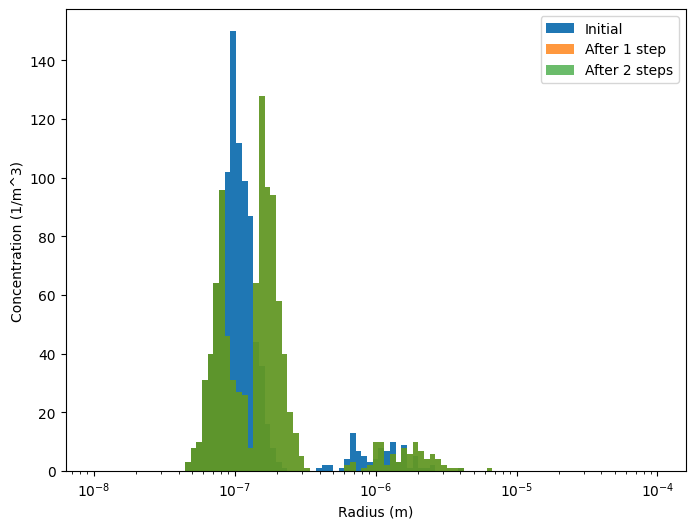

In [15]:
# define the condensation process
condensation_isothermal = CondensationIsothermal(
    molar_mass=np.array([molar_mass_water, molar_mass_ammonium_sulfate]),  # kg/mol
    accommodation_coefficient=0.1,  #makes things go slower/faster
    update_gases=False,
)
condensation_process = MassCondensation(condensation_strategy=condensation_isothermal)

# define the time array in seconds
time_step = 11
sub_steps = 10000
time_array = np.arange(0, 5, time_step)
total_mass = np.zeros_like(time_array)

# output arrays
aerosol_sim = []


fig, ax = plt.subplots(figsize=(8, 6))
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="Initial")

print(aerosol)
# one step
aerosol = condensation_process.execute(aerosol, time_step, sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="After 1 step", alpha=0.8)

print(aerosol)
# 10 seconds
aerosol = condensation_process.execute(aerosol, time_step, sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="After 2 steps", alpha=0.7)
print(aerosol)

ax.set_xscale("log")
# ax.set_yscale("log")
plt.legend()
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Concentration (1/m^3)")
plt.show()

## Small Particles Grow Faster

We can see from the previous example that the smaller particles grow faster than the larger particles. This is because the smaller particles have a higher surface area to volume ratio, which means they can take up more water.

However, that

## Summary

We built out the condensation process, and the equations that define the process. We also defined the inputs and outputs of the process. Next we will build out coagulation and nucleation processes, to complete the aerosol dynamics framework.